In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_csv("reviewsample2.csv")[['user_id','business_id','stars']][:100000]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
print(len(df))
n_users = df.user_id.unique().shape[0]
n_items = df.business_id.unique().shape[0]
print(n_users)
print(n_items)

100000
54163
5908


In [ ]:
df.head()

,user_id,business_id,stars
0,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0
1,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0
2,aq_ZxGHiri48TUXJlpRkCQ,Pthe4qk5xh4n-ef-9bvMSg,5.0
3,jOERvhmK6_lo_XGUBPws_w,Ws8V970-mQt2X9CwCuT5zw,4.0
4,HJECayULRM-6xh2GCCvLiA,l-nL4BmhzpZjcavooO48PQ,4.0


In [ ]:
n = 54163
m = 5908

In [ ]:
#mean square error
def mse(n,m,U,V,S_mat, S_dict, average = False):
    loss = 0
    num_elements = S_mat.nnz
    if not average:
        for (k,v) in S_dict.items():
            loss += (U[k[0],:].dot(V[k[1],:]) - v)**2
    else:
        for (k,v) in S_dict.items():
            loss += (U[k[0]]*V[k[1]] - v)**2      
    return (loss/num_elements)
    

In [ ]:
from scipy import sparse
from scipy.stats import uniform

In [ ]:
df.head(2)

,user_id,business_id,stars
0,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0
1,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0


In [ ]:
# prepare a mapping from id string to integer
user_map = {}
biz_map = {}
user_idx = 0
biz_idx = 0
for idx, row in df.iterrows():
    if row['user_id'] not in user_map:
        user_map[row['user_id']] = user_idx
        user_idx += 1
    if row['business_id'] not in biz_map:
        biz_map[row['business_id']] = biz_idx
        biz_idx += 1

In [ ]:
inv_user_map = {v: k for k, v in user_map.items()}
inv_biz_map = {v: k for k, v in biz_map.items()}

In [ ]:
i_index = []
j_index = []
s_rating = []
for idx, row in df.iterrows():
    i_index.append(user_map[row['user_id']])
    j_index.append(biz_map[row['business_id']])
    s_rating.append(float(row['stars']))

In [ ]:
S_mat = sparse.coo_matrix((s_rating, (i_index, j_index)))

In [ ]:
import scipy
from scipy.sparse.linalg import svds, eigs

In [ ]:
#Method 1: using SSVD
d = [1,2,5,10,20,50]
U, S, VT = svds(S_mat, k=d[1])

In [ ]:
U.shape

(54163, 2)

In [ ]:
S.shape

(2,)

In [ ]:
VT.shape

(2, 5908)

In [ ]:
len(user_map)

54163

In [ ]:
len(biz_map)

5908

In [ ]:
#Parse to dictionary
S_dict = {}
for idx, row in df.iterrows():
    S_dict[(user_map[row['user_id']], biz_map[row['business_id']])] = float(row['stars'])

In [ ]:
user_dict = {}
joke_dict = {}
for idx, row in df.iterrows():
    if user_map[row['user_id']] not in user_dict:
        user_dict[user_map[row['user_id']]] = [biz_map[row['business_id']]]
    else:
        user_dict[user_map[row['user_id']]].append(biz_map[row['business_id']])
        
    if biz_map[row['business_id']] not in joke_dict:
        joke_dict[biz_map[row['business_id']]] = [user_map[row['user_id']]]
    else:
        joke_dict[biz_map[row['business_id']]].append(user_map[row['user_id']])    

In [ ]:
# Method 3: Using SGD
lambda_ = 0.01
lr = 0.001
d = 2
U = np.random.rand(n,d)
V = np.random.rand(m,d)
loss = []
for iter in range(30):
    #fix u update v
    for j in range(m): 
        gradvj = 0
        for user_idx in joke_dict[j]:
            gradvj += (U[user_idx,:].dot(V[j,:]) - S_dict[(user_idx, j)])*U[user_idx,:] 
        gradvj += lambda_ *V[j,:]
        V[j,:] -= lr * gradvj
    
    
    #fix v update u
    for i in range(n): 
        gradui = 0
        for joke_idx in user_dict[i]:
            gradui += (U[i,:].dot(V[joke_idx,:]) - S_dict[(i, joke_idx)])*V[joke_idx,:] 
        gradui += lambda_ *U[i,:]
        U[i,:] -= lr * gradui
    
    loss.append(mse(n,m,U,V,S_mat, S_dict,average = False))
    print("mse loss:", loss[iter])

mse loss: 11.529570926805373
mse loss: 10.892126292618828
mse loss: 10.325547668402935
mse loss: 9.813684345323278
mse loss: 9.346431088447003
mse loss: 8.917061205343309
mse loss: 8.520742022652758
mse loss: 8.153723623456587
mse loss: 7.812914543543613
mse loss: 7.49566859389837
mse loss: 7.199678150463991
mse loss: 6.922916255167428
mse loss: 6.663598821094237
mse loss: 6.420154428306004
mse loss: 6.191197285807323
mse loss: 5.9755024128323875
mse loss: 5.771983235653532
mse loss: 5.579671920549902
mse loss: 5.397702549438994
mse loss: 5.225296999517807
mse loss: 5.061753222004862
mse loss: 4.906435543190107
mse loss: 4.758766611527644
mse loss: 4.618220657176131
mse loss: 4.484317789811399
mse loss: 4.356619120126549
mse loss: 4.234722541797424
mse loss: 4.118259051179332
mse loss: 4.006889512203441
mse loss: 3.9003017957714916


Text(0.5, 0, 'Epoch')

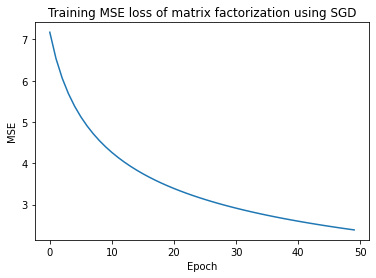

In [ ]:
plt.plot(loss)
plt.title("Training MSE loss of matrix factorization using SGD")
plt.ylabel("MSE")
plt.xlabel("Epoch")

In [ ]:
S_mat.getrow(0).toarray()[S_mat.getrow(0).toarray().nonzero()]

array([ 8.79, -7.52, -8.5 ,  4.17, -4.76,  8.45, -7.52, -7.43, -9.81,
       -9.37, -9.81, -8.5 ,  7.82,  7.82,  5.05,  4.95, -8.11, -9.03,
       -9.08, -6.26,  3.79,  3.93, -8.69,  3.2 ,  0.92,  2.82, -8.64,
        8.59,  3.59, -6.84, -9.03, -9.42,  2.82])

In [ ]:
(1,2) in S_dict

True

In [ ]:
len(S_dict)

904699

In [ ]:
print(n)
print(m)

8654
3461


In [ ]:
# Method 1: Taking average
U = np.ones(n)
#Predict V
V = np.zeros(m)
for j in range(m):
    if S_mat.getcol(j).nnz == 0:
        V[j] = 0
    else:
        V[j] = S_mat.getcol(j).sum()/S_mat.getcol(j).nnz


In [ ]:
print("mse train loss:", mse(n,m,U,V,S_mat, S_dict, average = 1))
print("mae train loss:", mae(n,m,U,V,S_mat, S_dict, average = 1))

mse train loss: 0.8748370027801576
mae train loss: 0.6563496670800273


In [ ]:
print("mse train loss:", mse(n,m,U,V,S_mat, S_dict, average = 1))
print("mae train loss:", mae(n,m,U,V,S_mat, S_dict, average = 1))

# print("mse test loss:", mse(n,m,U,V,S_mat_test, S_dict_test, average = 1))
# print("mae test loss:", mae(n,m,U,V,S_mat_test, S_dict_test, average = 1))

mse train loss: 24.870775408352657
mae train loss: 4.114385496106998
mse test loss: 24.867462528492833
mae test loss: 4.113832606397694


In [ ]:
print("MAE is: ", mae(n,m,U,V,S_mat, S_dict, average = True))

MAE is:  None


In [ ]:
# Method 2: using svd
d = [2,5]
for e in d:
    U, S, VT = svds(S_mat, k=e)
    print("SVD {} components".format(e))
    U = U*S
    print("mse train loss:", mse(n,m,U,VT.T,S_mat, S_dict, average = 1))
    print("mae train loss:", mae(n,m,U,VT.T,S_mat, S_dict, average = 1))


SVD 2 components
mse train loss: [15.60360436 15.57817905]
mae train loss: [3.69758335 3.6956044 ]
SVD 5 components
mse train loss: [15.60469278 15.60399209 15.59235419 15.60360436 15.57817905]
mae train loss: [3.70329865 3.69957124 3.69947579 3.69758335 3.6956044 ]


In [ ]:
def get_recommendation(query, top=5):
    if query in user_map:
        print("Found user: ", query)
        matrix_row = U.dot(V.T)[user_map[query],:]
        sorted_indices = np.argsort(-1*matrix_row)[:top]
        print("Top {} Recommendations: ".format(top))
        for i in sorted_indices:
            print("Business: ", inv_biz_map[i])    

In [ ]:
get_recommendation(query)

Found user:  HJECayULRM-6xh2GCCvLiA
Top 5 Recommendations: 
Business:  eaNenRk_liZBERFFLCXqqQ
Business:  1aVbXH_4uQCTQU7HfGmyow
Business:  Cd2ERofxOeCbCi-0yDs0aw
Business:  IhNASEZ3XnBHmuuVnWdIwA
Business:  S4qUsi44l5D9BbUCkhwQEA
